In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


input_folder = 'C:/Users/Davide/workspace/SoccerData/Input/'


In [3]:
def make_list(list_dict, key = 'id'):
    if len(list_dict) ==0:
        return []
    return [i['id'] for i in list_dict]

def select_player(name):
    print(player[player.lastName.str.contains(name)])

def select_from_event(df, Id=None, subId=None, tag = None):
    tag_list =[tag in i for i in df.tags] if tag is not None else [not tag in i for i in df.tags] 
    id_list = Id if Id is not None else df.eventId
    subid_list = subId if subId is not None else df.subEventId
    return df[(df.eventId == id_list) & tag_list & (df.subEventId == subid_list)]

#df raggruppato per partita
def get_percentage_event_WRT(df, Id=None, subId=None, tag = None, event_name = 'name'):
    df_by_event = select_from_event(df, Id, subId, tag)
    counter = df_by_event.groupby(['playerId','teamId']).size().reset_index().merge(df_by_event.groupby('teamId').size().reset_index(), on = 'teamId')
    counter.rename(columns={'0_x':'count_by_player','0_y':'total'}, inplace=True)
    counter[event_name + '_pct_WRT'] = counter.count_by_player/counter.total
    return counter.drop(['count_by_player','total','teamId'],1)



#df raggruppato per partita
def get_percentage_event_WRP(df, Id=None, subId=None, tag = None, event_name = 'name'):
    df_by_event = select_from_event(df, Id, subId, tag)
    counter = df_by_event.groupby(['playerId','teamId']).size().reset_index().merge(df.groupby(['playerId','teamId']).size().reset_index(), on = ['teamId','playerId'])
    counter.rename(columns={'0_x':'single_ev_player','0_y':'total_ev_player'}, inplace=True)
    counter[event_name + '_pct_WRP'] = counter.single_ev_player/counter.total_ev_player
    return counter.drop(['single_ev_player','total_ev_player','teamId'],1)



def annual_mean(total_events, Id=None, subId=None, tag = None, event_name = 'name'):
    df = select_from_event(total_events, Id, subId, tag)
    res = df.groupby('playerId').size()/total_events.groupby(['playerId']).matchId.nunique()
    res.to_csv('C:/Users/Davide/workspace/SoccerData/Output/' + event_name + '.csv')

In [4]:
player = pd.read_json(input_folder+ 'players.json')
event = pd.read_json(input_folder+ 'events.json')
match = pd.read_json(input_folder+ 'matches.json')
team = pd.read_json(input_folder+ 'teams.json')

In [116]:
N =event.groupby(['matchId','matchPeriod']).size().shape[0]
#spacchetto dict ruolo giocatore
player['role_teo'] = [i['code2'] for i in player.role]

#spacchetto dict dei tags
event.tags = event.tags.apply(make_list)
event.positions = [i if len(i)==2 else [i[0],i[0]] for i in event.positions.values]

In [117]:
def distance(d1,d2):
    return np.sqrt((d1['x']-d2['x'])**2+(d1['y']-d2['y'])**2)

In [118]:
def measure_total_distance(df):
    res = []
    ravel = df.positions.values.ravel()
    for i in range(len(ravel)-1):
        res.append(distance(ravel[i][0],ravel[i+1][0]))
    return sum(res)

In [119]:
event['total_distance'] = event.groupby(['matchId','matchPeriod','playerId']).apply(measure_total_distance).reset_index()[0]

In [120]:
event = event.merge(player[['wyId','role_teo']], left_on='playerId', right_on='wyId', how ='outer').drop('wyId',1)
event.head()

,eventId,eventName,eventSec,id,matchId,matchPeriod,playerId,positions,subEventId,subEventName,tags,teamId,total_distance,role_teo
0,8.0,Pass,2.530536,180423957.0,2575959.0,1H,8327.0,"[{'y': 52, 'x': 49}, {'y': 44, 'x': 43}]",85,Simple pass,[1801],3158.0,2478.152248,FW
1,1.0,Duel,10.796797,180423963.0,2575959.0,1H,8327.0,"[{'y': 25, 'x': 72}, {'y': 64, 'x': 82}]",11,Ground attacking duel,"[602, 703, 1801]",3158.0,1303.323909,FW
2,1.0,Duel,12.418937,180423965.0,2575959.0,1H,8327.0,"[{'y': 64, 'x': 82}, {'y': 18, 'x': 62}]",11,Ground attacking duel,"[701, 1802]",3158.0,866.439812,FW
3,1.0,Duel,28.483430,180423974.0,2575959.0,1H,8327.0,"[{'y': 29, 'x': 71}, {'y': 27, 'x': 69}]",11,Ground attacking duel,"[702, 1801]",3158.0,787.446379,FW
4,1.0,Duel,214.141153,180424051.0,2575959.0,1H,8327.0,"[{'y': 74, 'x': 72}, {'y': 30, 'x': 56}]",11,Ground attacking duel,"[602, 701, 1802]",3158.0,836.194081,FW


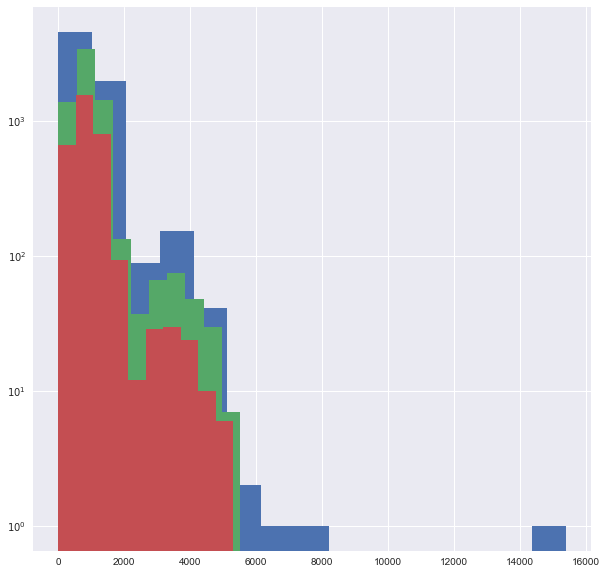

In [129]:
%matplotlib inline

plt.figure(figsize=(10,10))
event[event.role_teo=='DF'].total_distance.hist(bins = 15)
event[event.role_teo=='MD'].total_distance.hist(bins = 10)
event[event.role_teo=='FW'].total_distance.hist(bins = 10)
plt.yscale('log')

In [6]:
def get_pct(df,matchId, Id=None, subId=None, tag = None, event_name = 'name'):
    r1 = get_percentage_event_WRT(df, Id, subId, tag , event_name)
    #r1 = get_percentage_event_WRP(df, Id, subId, tag , event_name)

    #r2 = get_percentage_event_WRP(df, Id, subId, tag , event_name )
    #rr = r1.merge(r2, on = 'playerId')
    #rr['matchId'] = matchId
    r1['matchId'] = matchId[0]
    r1['period'] = matchId[1]
    return r1

In [ ]:
event_name = 'foul'
Id = 2
subId = 20
tag = None
type = 'team'

count = 0
res = []
for ix , df in event.groupby(['matchId','matchPeriod']):
    if count%100==0:
        print('Done {} perc'.format(count/N))
    res.append(get_pct(df, ix, Id = Id, subId=subId,tag=tag,event_name=event_name))
    r = pd.concat(res)
    #r.to_csv('C:/Users/Davide/workspace/SoccerData/Output/' + event_name + '.csv')
    count +=1
print('Done')

In [19]:
df = select_from_event(event,Id = 8)

In [24]:
(df.groupby('playerId').size() / event.groupby(['playerId']).matchId.nunique()).reset_index().rename(columns = {0:'event_name'})

,playerId,event_name
0,0,0.015789
1,45,26.600000
2,114,43.500000
3,122,25.605263
4,130,41.861111
5,174,23.062500
6,192,33.933333
7,394,43.592593
8,625,46.735294
9,658,7.333333


In [7]:
l = [{'event_name': 'assist', 'Id': None, 'subId': None, 'tag': 301},
    {'event_name': 'gol', 'Id': None, 'subId': None, 'tag': 101},
    {'event_name': 'yellow_card', 'Id': None, 'subId': None, 'tag': 1702}]

In [8]:
def create(Id,subId,tag,event_name=None, type =''):
    res = []
    for ix , df in event.groupby(['matchId','matchPeriod']):
        res.append(get_pct(df, ix, Id = Id, subId=subId,tag=tag,event_name=event_name))
    return pd.concat(res)

In [9]:
r = [create(**i) for i in l[:2]]

In [12]:
from functools import reduce


df1 = reduce(lambda x, y: pd.merge(x, y, on = ['matchId','playerId','period'], how = 'outer'), r)#.fillna(0.)


In [13]:
df1

,playerId,foul_pct_WRT,matchId,period,accurate_pass_pct_WRT
0,114,0.333333,2575959,1H,0.111842
1,8306,0.111111,2575959,1H,0.144737
2,20438,0.111111,2575959,1H,0.111842
3,20518,0.333333,2575959,1H,0.105263
4,23149,0.111111,2575959,1H,0.046053
5,20404,0.285714,2575959,1H,0.093960
6,20841,0.142857,2575959,1H,0.154362
7,21620,0.142857,2575959,1H,0.040268
8,41034,0.142857,2575959,1H,0.080537
9,49991,0.142857,2575959,1H,0.161074


In [24]:
# from joblib import Parallel, delayedø

# result = Parallel(n_jobs=-1)(delayed(get_pct)(df, ix, Id = 8) for ix,df in event.groupby('matchId'))

In [5]:
event

,eventId,eventName,eventSec,id,matchId,matchPeriod,playerId,positions,subEventId,subEventName,tags,teamId
0,8,Pass,2.530536,180423957,2575959,1H,8327,"[{'y': 52, 'x': 49}, {'y': 44, 'x': 43}]",85,Simple pass,[{'id': 1801}],3158
1,8,Pass,3.768418,180423958,2575959,1H,20438,"[{'y': 44, 'x': 43}, {'y': 17, 'x': 36}]",85,Simple pass,[{'id': 1801}],3158
2,7,Others on the ball,4.868265,180423959,2575959,1H,8306,"[{'y': 17, 'x': 36}, {'y': 56, 'x': 78}]",72,Touch,[],3158
3,1,Duel,8.114676,180423960,2575959,1H,8306,"[{'y': 56, 'x': 78}, {'y': 15, 'x': 64}]",11,Ground attacking duel,"[{'id': 504}, {'id': 703}, {'id': 1801}]",3158
4,1,Duel,8.647892,180423961,2575959,1H,8306,"[{'y': 15, 'x': 64}, {'y': 15, 'x': 72}]",11,Ground attacking duel,"[{'id': 503}, {'id': 703}, {'id': 1801}]",3158
5,8,Pass,10.376066,180423962,2575959,1H,8306,"[{'y': 15, 'x': 72}, {'y': 25, 'x': 72}]",85,Simple pass,[{'id': 1801}],3158
6,1,Duel,10.796797,180423963,2575959,1H,8327,"[{'y': 25, 'x': 72}, {'y': 64, 'x': 82}]",11,Ground attacking duel,"[{'id': 602}, {'id': 703}, {'id': 1801}]",3158
7,1,Duel,11.527556,180423976,2575959,1H,86366,"[{'y': 85, 'x': 36}, {'y': 75, 'x': 28}]",12,Ground defending duel,"[{'id': 504}, {'id': 701}, {'id': 1802}]",3172
8,1,Duel,12.156579,180423977,2575959,1H,20404,"[{'y': 75, 'x': 28}, {'y': 36, 'x': 18}]",12,Ground defending duel,"[{'id': 601}, {'id': 701}, {'id': 1802}]",3172
9,1,Duel,12.418937,180423965,2575959,1H,8327,"[{'y': 64, 'x': 82}, {'y': 18, 'x': 62}]",11,Ground attacking duel,"[{'id': 701}, {'id': 1802}]",3158
